# 01. Simulate Event Related Potentials (ERPs)

This example demonstrates how to simulate a threshold level tactile
evoked response, as detailed in the [HNN GUI ERP tutorial](https://jonescompneurolab.github.io/hnn-tutorials/erp/erp),
using HNN-core. We recommend you first review the GUI tutorial.

The workflow below recreates an example of the threshold level tactile
evoked response, as observed in Jones et al. J. Neuroscience 2007 [1]_
(e.g. Figure 7 in the GUI tutorial), albeit without a direct comparison
to the recorded data.


In [1]:
# Authors: Mainak Jas <mmjas@mgh.harvard.edu>
#          Sam Neymotin <samnemo@gmail.com>
#          Blake Caldwell <blake_caldwell@brown.edu>
#          Christopher Bailey <cjb@cfin.au.dk>

# sphinx_gallery_thumbnail_number = 3

import os.path as op
import tempfile

import matplotlib.pyplot as plt 

Let us import hnn_core



In [2]:
import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole

--No graphics will be displayed.


Let us first create our default network and visualize the cells
inside it.



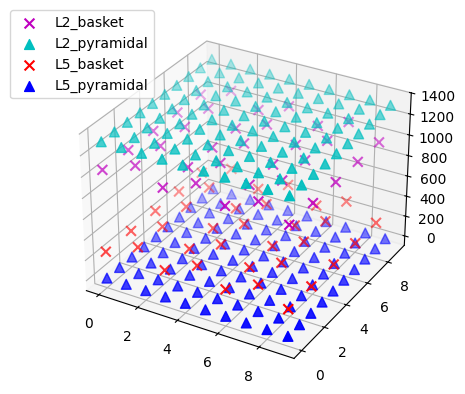

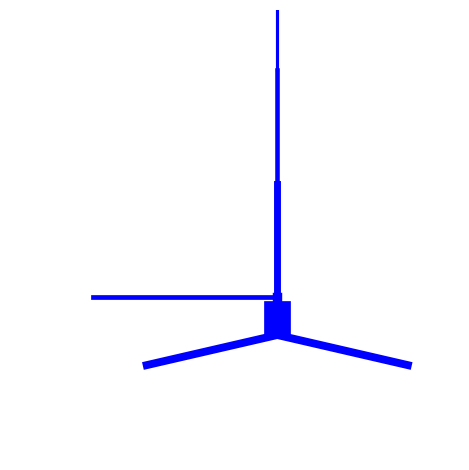

In [3]:
net = jones_2009_model()
net.plot_cells()
net.cell_types['L5_pyramidal'].plot_morphology();

The network of cells is now defined, to which we add external drives as
required. Weights are prescribed separately for AMPA and NMDA receptors
(receptors that are not used can be omitted or set to zero). The possible
drive types include the following (click on the links for documentation):

- :meth:`hnn_core.Network.add_evoked_drive`
- :meth:`hnn_core.Network.add_poisson_drive`
- :meth:`hnn_core.Network.add_bursty_drive`



First, we add a distal evoked drive



In [4]:
weights_ampa_d1 = {'L2_basket': 0.006562, 'L2_pyramidal': .000007,
                   'L5_pyramidal': 0.142300}
weights_nmda_d1 = {'L2_basket': 0.019482, 'L2_pyramidal': 0.004317,
                   'L5_pyramidal': 0.080074}
synaptic_delays_d1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                      'L5_pyramidal': 0.1}
net.add_evoked_drive(
    'evdist1', mu=63.53, sigma=3.85, numspikes=1, weights_ampa=weights_ampa_d1,
    weights_nmda=weights_nmda_d1, location='distal',
    synaptic_delays=synaptic_delays_d1, event_seed=274)

Then, we add two proximal drives



In [5]:
weights_ampa_p1 = {'L2_basket': 0.08831, 'L2_pyramidal': 0.01525,
                   'L5_basket': 0.19934, 'L5_pyramidal': 0.00865}
synaptic_delays_prox = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                        'L5_basket': 1., 'L5_pyramidal': 1.}
# all NMDA weights are zero; pass None explicitly
net.add_evoked_drive(
    'evprox1', mu=26.61, sigma=2.47, numspikes=1, weights_ampa=weights_ampa_p1,
    weights_nmda=None, location='proximal',
    synaptic_delays=synaptic_delays_prox, event_seed=544)

# Second proximal evoked drive. NB: only AMPA weights differ from first
weights_ampa_p2 = {'L2_basket': 0.000003, 'L2_pyramidal': 1.438840,
                   'L5_basket': 0.008958, 'L5_pyramidal': 0.684013}
# all NMDA weights are zero; omit weights_nmda (defaults to None)
net.add_evoked_drive(
    'evprox2', mu=137.12, sigma=8.33, numspikes=1,
    weights_ampa=weights_ampa_p2, location='proximal',
    synaptic_delays=synaptic_delays_prox, event_seed=814)

Now let's simulate the dipole, running 2 trials with the
`hnn_core.parallel_backends.Joblib` backend.
To run them in parallel we could set ``n_jobs`` to equal the number of
trials. The ``Joblib`` backend allows running the simulations in parallel
across trials.



In [6]:
from hnn_core import JoblibBackend

with JoblibBackend(n_jobs=2):
    dpls = simulate_dipole(net, tstop=170., n_trials=2)

Joblib will run 2 trial(s) in parallel by distributing trials over 2 jobs.


--No graphics will be displayed.
--No graphics will be displayed.


Loading custom mechanism files from /opt/homebrew/Caskroom/miniconda/base/envs/website-redesign/lib/python3.12/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /opt/homebrew/Caskroom/miniconda/base/envs/website-redesign/lib/python3.12/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
[Done]
[Done]
Trial 1: 0.03 ms...
Trial 2: 0.03 ms...
Trial 1: 10.0 ms...
Trial 2: 10.0 ms...
Trial 1: 20.0 ms...
Trial 2: 20.0 ms...
Trial 1: 30.0 ms...
Trial 2: 30.0 ms...
Trial 1: 40.0 ms...
Trial 2: 40.0 ms...
Trial 1: 50.0 ms...
Trial 2: 50.0 ms...
Trial 1: 60.0 ms...
Trial 2: 60.0 ms...
Trial 1: 70.0 ms...
Trial 2: 70.0 ms...
Trial 1: 80.0 ms...
Trial 2: 80.0 ms...
Trial 1: 90.0 ms...
Trial 2: 90.0 ms...
Trial 1: 100.0 ms...
Trial 2: 100.0 ms...
Trial 1: 110.0 ms...
Trial 2: 110.0 ms...
Trial 1: 120.0 ms...
Trial 2: 120.0 ms...
Trial 1: 130.0 ms...
Trial 2: 130.0 ms...
Trial 1: 140.0 ms...
Trial 2: 140.0 ms

Rather than reading smoothing and scaling parameters from file, we recommend
explicit use of the `~hnn_core.dipole.Dipole.smooth` and
`~hnn_core.dipole.Dipole.scale` methods instead. Note that both methods
operate in-place, i.e., the objects are modified.



In [7]:
window_len, scaling_factor = 30, 3000
for dpl in dpls:
    dpl.smooth(window_len).scale(scaling_factor)

Plot the amplitudes of the simulated aggregate dipole moments over time



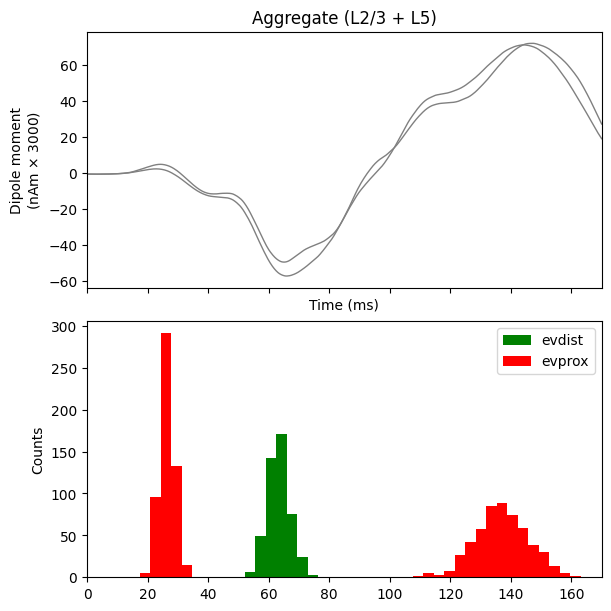

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6),
                         constrained_layout=True)
plot_dipole(dpls, ax=axes[0], layer='agg', show=False)
net.cell_response.plot_spikes_hist(ax=axes[1],
                                   spike_types=['evprox', 'evdist']);

If you want to analyze how the different cortical layers contribute to
different net waveform features, then instead of passing ``'agg'`` to
``layer``, you can provide a list of layers to be visualized and optionally
a list of axes to ``ax`` to visualize the dipole moments separately.



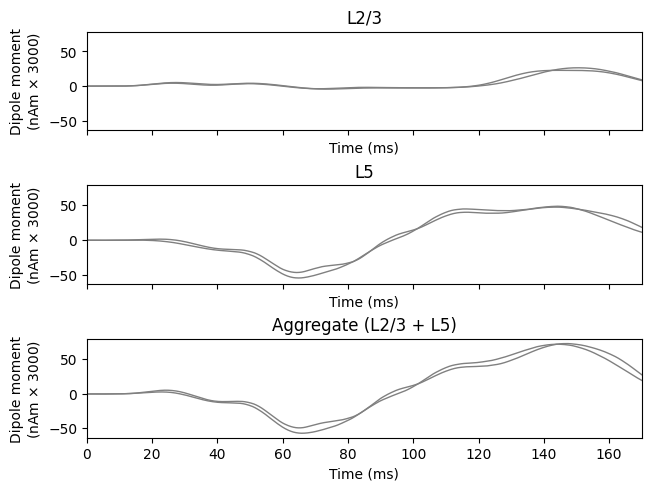

In [9]:
plot_dipole(dpls, average=False, layer=['L2', 'L5', 'agg'], show=False);

Now, let us try to make the exogenous driving inputs to the cells
synchronous and see what happens. This is achieved by setting
``n_drive_cells=1`` and ``cell_specific=False`` when adding each drive.



In [10]:
net_sync = jones_2009_model()

n_drive_cells=1
cell_specific=False

net_sync.add_evoked_drive(
    'evdist1', mu=63.53, sigma=3.85, numspikes=1, weights_ampa=weights_ampa_d1,
    weights_nmda=weights_nmda_d1, location='distal', n_drive_cells=n_drive_cells,
    cell_specific=cell_specific, synaptic_delays=synaptic_delays_d1, event_seed=274)

net_sync.add_evoked_drive(
    'evprox1', mu=26.61, sigma=2.47, numspikes=1, weights_ampa=weights_ampa_p1,
    weights_nmda=None, location='proximal', n_drive_cells=n_drive_cells,
    cell_specific=cell_specific, synaptic_delays=synaptic_delays_prox, event_seed=544)

net_sync.add_evoked_drive(
    'evprox2', mu=137.12, sigma=8.33, numspikes=1,
    weights_ampa=weights_ampa_p2, location='proximal', n_drive_cells=n_drive_cells,
    cell_specific=cell_specific, synaptic_delays=synaptic_delays_prox, event_seed=814)

You may interrogate current values defining the spike event time dynamics by



In [11]:
print(net_sync.external_drives['evdist1']['dynamics'])

{'mu': 63.53, 'sigma': 3.85, 'numspikes': 1}


Finally, let's simulate this network. Rather than modifying the dipole
object, this time we make a copy of it before smoothing and scaling.



Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /opt/homebrew/Caskroom/miniconda/base/envs/website-redesign/lib/python3.12/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...


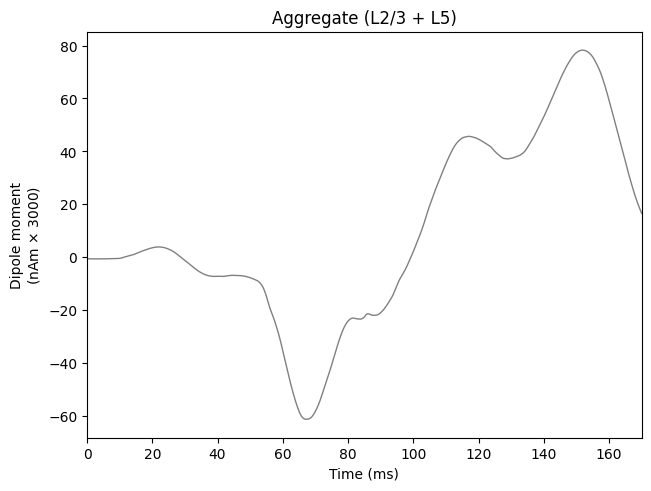

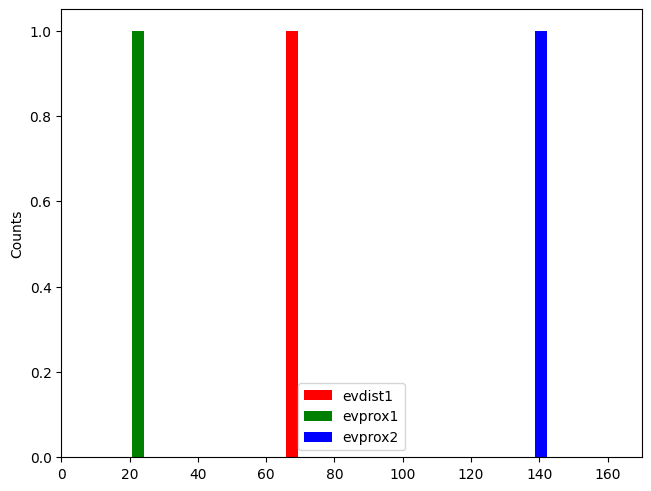

In [12]:
dpls_sync = simulate_dipole(net_sync, tstop=170., n_trials=1)

trial_idx = 0
dpls_sync[trial_idx].copy().smooth(window_len).scale(scaling_factor).plot()
net_sync.cell_response.plot_spikes_hist();

<h4>Warning</h4>

- Always look at dipoles in conjunction with raster plots and spike histogram to avoid misinterpretation.

- Run multiple trials of your simulation to get an average of different drives seeds before drawing conclusions.



## References
.. [1] Jones, Stephanie R., et al. "Neural correlates of tactile detection:
       a combined magnetoencephalography and biophysically based computational
       modeling study." Journal of Neuroscience 27.40 (2007): 10751-10764.

